In [1]:
import pandas as pd
import re
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Dropout, RepeatVector
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# import torch
# from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from nltk.tokenize import word_tokenize
from itertools import chain

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_excel('recipes.xlsx')
df.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL
0,Bourbon Chicken,I searched and finally found this recipe on th...,"{'Ready In:': '35mins', 'Ingredients:': '11', ...",Editor's Note: Named Bourbon Chicken because i...,"2 lbs boneless chicken breasts, cut into bite-...","{'Serving Size': '1 (330) g', 'Servings Per Re...",Chicken Breast,4.58,https://www.food.com/recipe/bourbon-chicken-45809
1,Best Banana Bread,You'll never need another banana bread recipe ...,"{'Ready In:': '1hr 10mins', 'Ingredients:': '8...",Remove odd pots and pans from oven.\nPreheat o...,"1⁄2 cup butter, softened\n1 cup granulated sug...","{'Serving Size': '1 (96) g', 'Servings Per Rec...",Quick Breads,4.81,https://www.food.com/recipe/best-banana-bread-...
2,To Die for Crock Pot Roast,"Amazing flavor, and so simple! No salt needed ...","{'Ready In:': '9hrs 5mins', 'Ingredients:': '5...",Place beef roast in crock pot.\nMix the dried ...,"1 (4 -5 lb) beef roast, any kind\n1 (1 1/4 oun...","{'Serving Size': '1 (245) g', 'Servings Per Re...",One-Dish Meal,4.58,https://www.food.com/recipe/to-die-for-crock-p...
3,Crock-Pot Chicken With Black Beans & Cream Cheese,I love this Crock-Pot chicken recipe for two r...,"{'Ready In:': '4hrs 3mins', 'Ingredients:': '5...","Take 4-5 frozen, yes, frozen, boneless chicken...","4 -5 boneless chicken breasts, frozen\n1 (15 1...","{'Serving Size': '1 (493) g', 'Servings Per Re...",One-Dish Meal,4.46,https://www.food.com/recipe/crock-pot-chicken-...
4,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,"{'Ready In:': '25mins', 'Ingredients:': '12', ...",Place chicken and Cajun seasoning in a bowl an...,"2 boneless skinless chicken breast halves, cut...","{'Serving Size': '1 (373) g', 'Servings Per Re...",Chicken Breast,4.84,https://www.food.com/recipe/creamy-cajun-chick...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11694 entries, 0 to 11693
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         11694 non-null  object 
 1   Description  11351 non-null  object 
 2   Facts        11694 non-null  object 
 3   Directions   11694 non-null  object 
 4   Ingredients  11694 non-null  object 
 5   Nutrition    11694 non-null  object 
 6   Category     11691 non-null  object 
 7   Rating       11694 non-null  float64
 8   URL          11694 non-null  object 
dtypes: float64(1), object(8)
memory usage: 822.4+ KB


In [4]:
df['Category'].unique()

array(['Chicken Breast', 'Quick Breads', 'One-Dish Meal', 'Drop Cookies',
       'Dessert', 'Meatloaf', 'Spaghetti', 'Bars', 'Beverages',
       'Breakfast', 'Meat', 'Chicken Thigh & Leg', 'Potato', 'Breads',
       'Winter', 'Whole Chicken', 'Lunch', 'Pork', 'Chicken',
       'Cookie and Brownie', 'Long-Grain Rice', 'Clear Soups', 'Sauces',
       'Cheese', 'Oven', 'Tilapia', '< 60 Mins', 'Vegetable',
       'Black Beans', 'Very Low Carbs', 'Yeast', 'Pie', 'Lentils', 'Tuna',
       'Poultry', 'Penne', 'Oranges', 'Cauliflower', 'Greek', 'Candy',
       'Ham', '< 30 Mins', 'Steak', 'Summer', 'Tex-Mex', 'Stew',
       'Mexican', 'Chowders', 'High Protein', 'Grains', 'Whole Turkey',
       'Kid-Friendly', 'Low Cholesterol', 'Roast Beef',
       'Chocolate Chip Cookies', 'Spreads', 'Fruit', 'Low Protein',
       '< 15 Mins', 'Corn', 'Yam/Sweet Potato', 'Roast', 'European',
       'Norwegian', 'Salad Dressings', 'Cheesecake', 'Onions',
       'Household Cleaners', 'Beans', 'Chinese', 'Curri

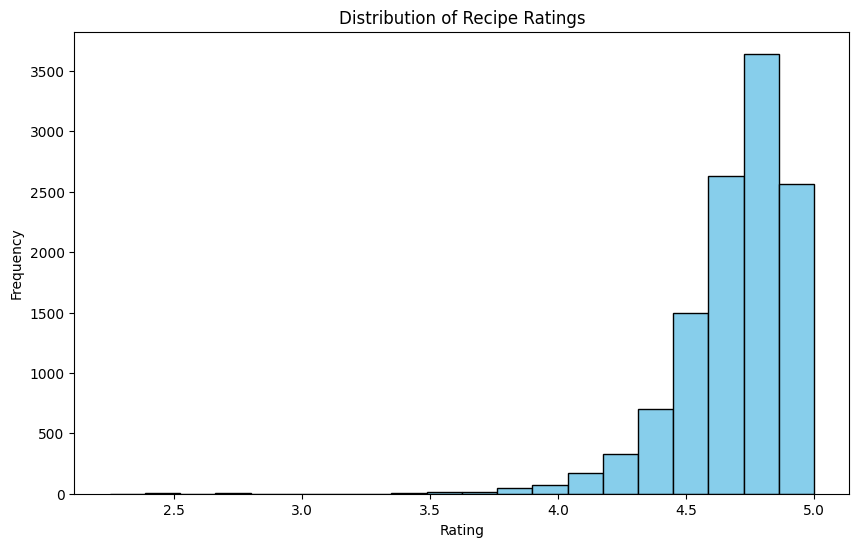

In [5]:
plt.figure(figsize=(10, 6))
df['Rating'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Recipe Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

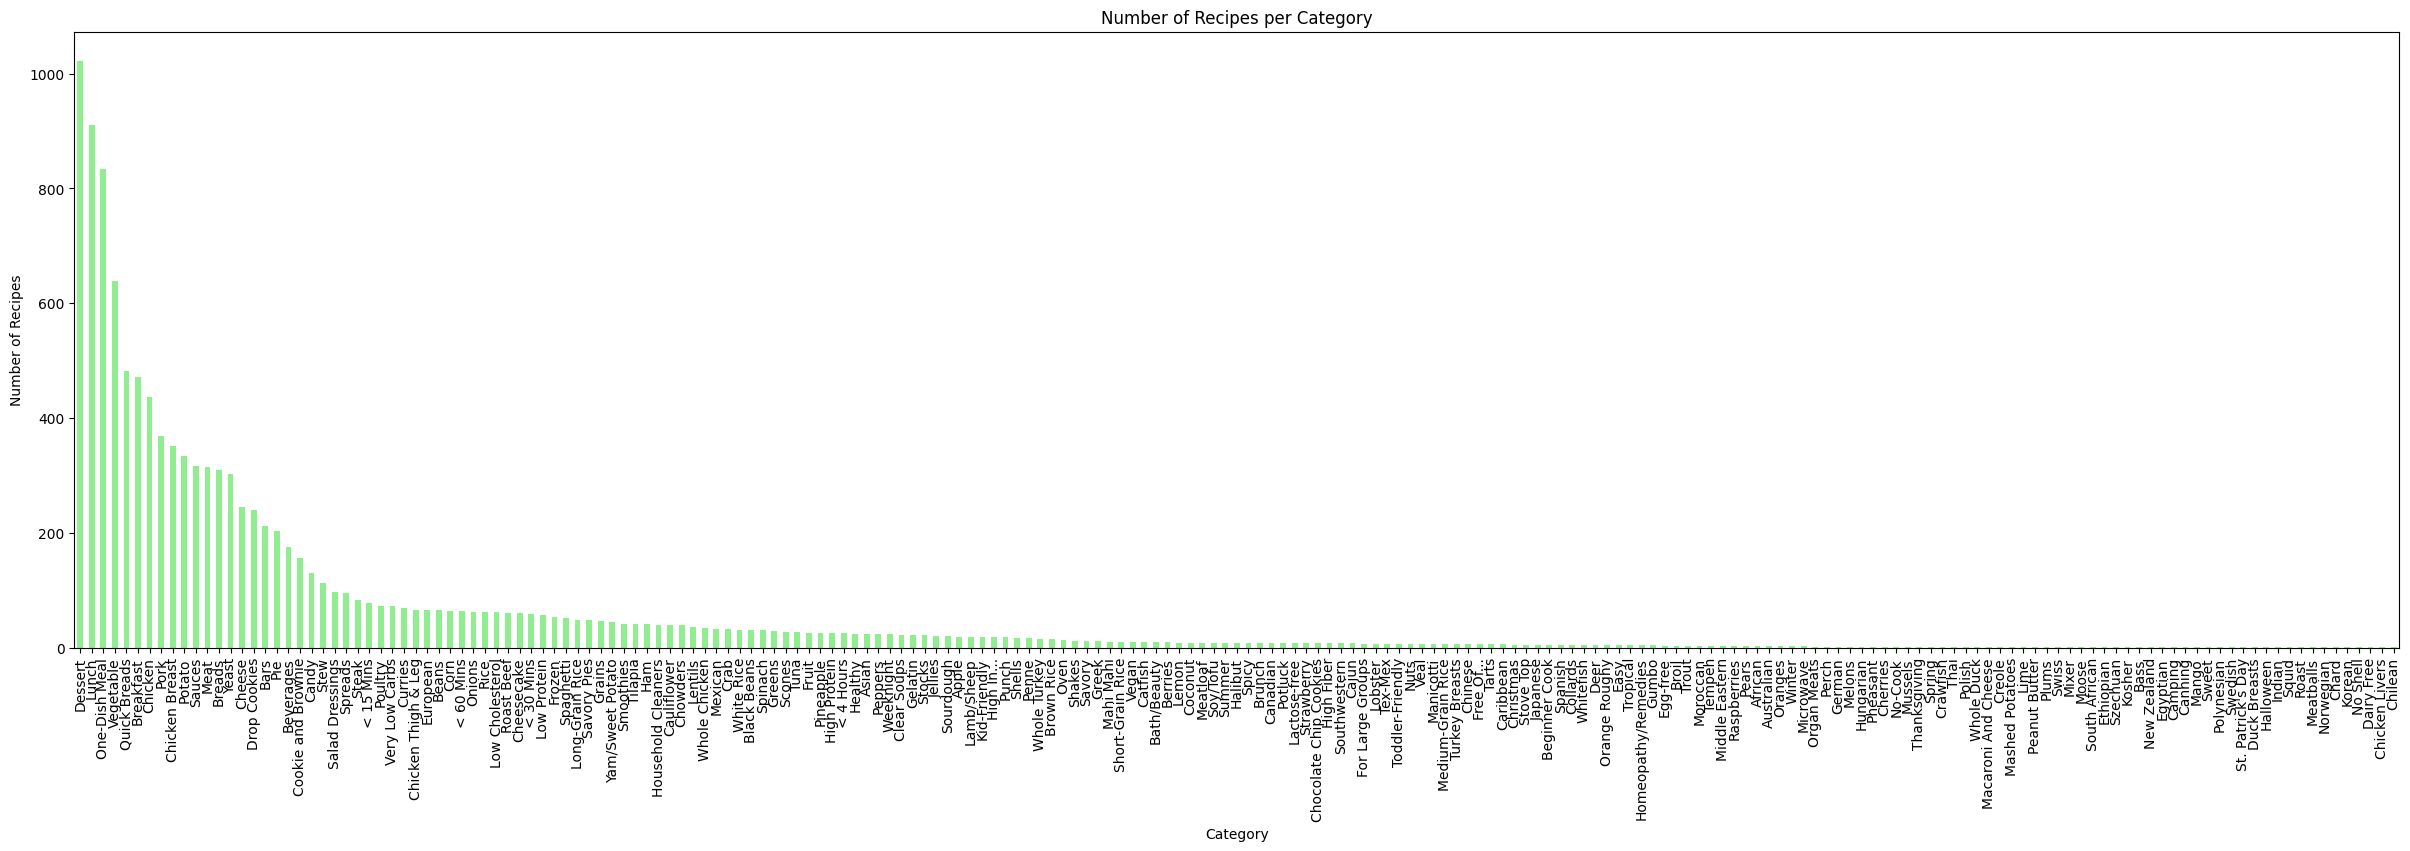

In [6]:
plt.figure(figsize=(30, 8))
df['Category'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Number of Recipes per Category')
plt.xlabel('Category')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=90)
plt.show()

In [7]:
# preparation of facts column
all_keys = []
for facts in df['Facts']:
    try:
        facts_dict = json.loads(facts.replace("'", '"'))
        all_keys.extend(facts_dict.keys())
    except json.JSONDecodeError:
        continue
unique_keys = set(all_keys)
unique_keys

{'Ingredients:', 'Ready In:', 'Serves:', 'Yields:'}

In [8]:
def extract_facts(x):
    try:
        data = json.loads(x['Facts'].replace('"', " ").replace("'", '"'))
        for k in unique_keys:
            key = f"Fact_{k.replace(':', '')}"
            x[key] = data.get(k, None)
        return x
    except Exception as e:
        print(x)
        print(e)

df = df.apply(extract_facts, axis=1)

Name                                                  Olga Bread
Description    Olga bread just like from the restaurants. I f...
Facts          {'Ready In:': '45mins', 'Ingredients:': '9', '...
Directions     Scald milk, remove to large bowl.\nAdd honey, ...
Ingredients    1 cup milk\n1⁄4 cup honey\n1⁄4 cup margarine\n...
Nutrition      {'Serving Size': '1 (1013) g', 'Servings Per R...
Category                                                  Breads
Rating                                                      4.71
URL                 https://www.food.com/recipe/olga-bread-79388
Name: 4065, dtype: object
Expecting ',' delimiter: line 1 column 61 (char 60)
Name                                        Coca-Cola Pork Roast
Description    There are lots of cola/meat recipes on this si...
Facts          {'Ready In:': '8hrs 5mins', 'Ingredients:': '4...
Directions     Rub the roast with salt and pepper then place ...
Ingredients    3 -4 lbs roast (I used boneless pork shoulder ...
Nutrition   

In [9]:
df.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields
0,Bourbon Chicken,I searched and finally found this recipe on th...,"{'Ready In:': '35mins', 'Ingredients:': '11', ...",Editor's Note: Named Bourbon Chicken because i...,"2 lbs boneless chicken breasts, cut into bite-...","{'Serving Size': '1 (330) g', 'Servings Per Re...",Chicken Breast,4.58,https://www.food.com/recipe/bourbon-chicken-45809,4,11,35mins,None
1,Best Banana Bread,You'll never need another banana bread recipe ...,"{'Ready In:': '1hr 10mins', 'Ingredients:': '8...",Remove odd pots and pans from oven.\nPreheat o...,"1⁄2 cup butter, softened\n1 cup granulated sug...","{'Serving Size': '1 (96) g', 'Servings Per Rec...",Quick Breads,4.81,https://www.food.com/recipe/best-banana-bread-...,10,8,1hr 10mins,1 loaf
2,To Die for Crock Pot Roast,"Amazing flavor, and so simple! No salt needed ...","{'Ready In:': '9hrs 5mins', 'Ingredients:': '5...",Place beef roast in crock pot.\nMix the dried ...,"1 (4 -5 lb) beef roast, any kind\n1 (1 1/4 oun...","{'Serving Size': '1 (245) g', 'Servings Per Re...",One-Dish Meal,4.58,https://www.food.com/recipe/to-die-for-crock-p...,8,5,9hrs 5mins,None
3,Crock-Pot Chicken With Black Beans & Cream Cheese,I love this Crock-Pot chicken recipe for two r...,"{'Ready In:': '4hrs 3mins', 'Ingredients:': '5...","Take 4-5 frozen, yes, frozen, boneless chicken...","4 -5 boneless chicken breasts, frozen\n1 (15 1...","{'Serving Size': '1 (493) g', 'Servings Per Re...",One-Dish Meal,4.46,https://www.food.com/recipe/crock-pot-chicken-...,4,5,4hrs 3mins,None
4,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,"{'Ready In:': '25mins', 'Ingredients:': '12', ...",Place chicken and Cajun seasoning in a bowl an...,"2 boneless skinless chicken breast halves, cut...","{'Serving Size': '1 (373) g', 'Servings Per Re...",Chicken Breast,4.84,https://www.food.com/recipe/creamy-cajun-chick...,2,12,25mins,None


In [10]:
# Function to extract specific nutrition information

keys = ['Serving Size', 'Servings Per Recipe', 'Calories from Fat', 'Total Fat', 'Saturated Fat', 'Cholesterol',
        'Sodium', 'Total Carbohydrate', 'Dietary Fiber', 'Sugars', 'Protein']

def extract_quantity(text):
    if "mg" in text:
        return float(text.replace("mg", "").strip())
    elif "g" in text:
        grams = float(text.replace("g", "").strip())
        return grams * 1000
    else:
        return float(text.strip())

def extract_nutrition_info(x):
    try:
        nutrition = json.loads(x['Nutrition'].replace("'", '"'))
    
        for k in keys:
            for key in nutrition:
                if key.startswith(k):
                    if(k in keys[0:2]):
                        x[k] = nutrition.get(key)
                    else:
                        x[f"{k} DV"] = int(nutrition.get(key).replace("%", "").strip())
                        x[k] = extract_quantity(key.replace(k, ''))
        return x
    except Exception as e:
        print(x)
        print(e)

df = df.apply(extract_nutrition_info, axis=1)

Name                None
Description         None
Facts               None
Directions          None
Ingredients         None
Nutrition           None
Category            None
Rating               NaN
URL                 None
Fact_Serves         None
Fact_Ingredients    None
Fact_Ready In       None
Fact_Yields         None
Name: 4065, dtype: object
'NoneType' object has no attribute 'replace'
Name                None
Description         None
Facts               None
Directions          None
Ingredients         None
Nutrition           None
Category            None
Rating               NaN
URL                 None
Fact_Serves         None
Fact_Ingredients    None
Fact_Ready In       None
Fact_Yields         None
Name: 4584, dtype: object
'NoneType' object has no attribute 'replace'
Name                None
Description         None
Facts               None
Directions          None
Ingredients         None
Nutrition           None
Category            None
Rating               NaN
URL     

In [11]:
df.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein
0,Bourbon Chicken,I searched and finally found this recipe on th...,"{'Ready In:': '35mins', 'Ingredients:': '11', ...",Editor's Note: Named Bourbon Chicken because i...,"2 lbs boneless chicken breasts, cut into bite-...","{'Serving Size': '1 (330) g', 'Servings Per Re...",Chicken Breast,4.58,https://www.food.com/recipe/bourbon-chicken-45809,4,11,35mins,None,1 (330) g,4,42.0,220000.0,37.0,24500.0,32.0,6500.0,48.0,145.3,65.0,1573.0,7.0,23400.0,1.0,300.0,85.0,21500.0,100.0,50100.0
1,Best Banana Bread,You'll never need another banana bread recipe ...,"{'Ready In:': '1hr 10mins', 'Ingredients:': '8...",Remove odd pots and pans from oven.\nPreheat o...,"1⁄2 cup butter, softened\n1 cup granulated sug...","{'Serving Size': '1 (96) g', 'Servings Per Rec...",Quick Breads,4.81,https://www.food.com/recipe/best-banana-bread-...,10,8,1hr 10mins,1 loaf,1 (96) g,10,35.0,94000.0,16.0,10500.0,31.0,6200.0,20.0,61.6,14.0,338.3,14.0,42500.0,5.0,1400.0,97.0,24400.0,7.0,3700.0
2,To Die for Crock Pot Roast,"Amazing flavor, and so simple! No salt needed ...","{'Ready In:': '9hrs 5mins', 'Ingredients:': '5...",Place beef roast in crock pot.\nMix the dried ...,"1 (4 -5 lb) beef roast, any kind\n1 (1 1/4 oun...","{'Serving Size': '1 (245) g', 'Servings Per Re...",One-Dish Meal,4.58,https://www.food.com/recipe/to-die-for-crock-p...,8,5,9hrs 5mins,None,1 (245) g,8,30.0,87000.0,14.0,9700.0,19.0,3900.0,49.0,149.8,15.0,380.6,0.0,2600.0,0.0,100.0,0.0,0.0,99.0,49500.0
3,Crock-Pot Chicken With Black Beans & Cream Cheese,I love this Crock-Pot chicken recipe for two r...,"{'Ready In:': '4hrs 3mins', 'Ingredients:': '5...","Take 4-5 frozen, yes, frozen, boneless chicken...","4 -5 boneless chicken breasts, frozen\n1 (15 1...","{'Serving Size': '1 (493) g', 'Servings Per Re...",One-Dish Meal,4.46,https://www.food.com/recipe/crock-pot-chicken-...,4,5,4hrs 3mins,None,1 (493) g,4,46.0,315000.0,53.0,35000.0,75.0,15200.0,51.0,155.3,38.0,913.4,16.0,50100.0,44.0,11200.0,39.0,9900.0,91.0,45900.0
4,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,"{'Ready In:': '25mins', 'Ingredients:': '12', ...",Place chicken and Cajun seasoning in a bowl an...,"2 boneless skinless chicken breast halves, cut...","{'Serving Size': '1 (373) g', 'Servings Per Re...",Chicken Breast,4.84,https://www.food.com/recipe/creamy-cajun-chick...,2,12,25mins,None,1 (373) g,2,52.0,370000.0,63.0,41100.0,120.0,24000.0,66.0,198.6,34.0,816.8,15.0,47400.0,10.0,2500.0,12.0,3100.0,78.0,39300.0


In [12]:
def convert_to_minutes(time_str):
    try:
        hour_pattern = re.compile(r'(\d+)\s*hr')
        minute_pattern = re.compile(r'(\d+)\s*min')
        
        # Find all matches for hours and minutes
        hours = hour_pattern.findall(time_str)
        minutes = minute_pattern.findall(time_str)
        
        # Convert matches to integers and calculate total minutes
        total_minutes = 0
        if hours:
            total_minutes += int(hours[0]) * 60
        if minutes:
            total_minutes += int(minutes[0])
        
        return total_minutes
    except Exception as e:
        return 0

df['Fact_Ready In'] = df['Fact_Ready In'].apply(convert_to_minutes)
df.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein
0,Bourbon Chicken,I searched and finally found this recipe on th...,"{'Ready In:': '35mins', 'Ingredients:': '11', ...",Editor's Note: Named Bourbon Chicken because i...,"2 lbs boneless chicken breasts, cut into bite-...","{'Serving Size': '1 (330) g', 'Servings Per Re...",Chicken Breast,4.58,https://www.food.com/recipe/bourbon-chicken-45809,4,11,35,None,1 (330) g,4,42.0,220000.0,37.0,24500.0,32.0,6500.0,48.0,145.3,65.0,1573.0,7.0,23400.0,1.0,300.0,85.0,21500.0,100.0,50100.0
1,Best Banana Bread,You'll never need another banana bread recipe ...,"{'Ready In:': '1hr 10mins', 'Ingredients:': '8...",Remove odd pots and pans from oven.\nPreheat o...,"1⁄2 cup butter, softened\n1 cup granulated sug...","{'Serving Size': '1 (96) g', 'Servings Per Rec...",Quick Breads,4.81,https://www.food.com/recipe/best-banana-bread-...,10,8,70,1 loaf,1 (96) g,10,35.0,94000.0,16.0,10500.0,31.0,6200.0,20.0,61.6,14.0,338.3,14.0,42500.0,5.0,1400.0,97.0,24400.0,7.0,3700.0
2,To Die for Crock Pot Roast,"Amazing flavor, and so simple! No salt needed ...","{'Ready In:': '9hrs 5mins', 'Ingredients:': '5...",Place beef roast in crock pot.\nMix the dried ...,"1 (4 -5 lb) beef roast, any kind\n1 (1 1/4 oun...","{'Serving Size': '1 (245) g', 'Servings Per Re...",One-Dish Meal,4.58,https://www.food.com/recipe/to-die-for-crock-p...,8,5,545,None,1 (245) g,8,30.0,87000.0,14.0,9700.0,19.0,3900.0,49.0,149.8,15.0,380.6,0.0,2600.0,0.0,100.0,0.0,0.0,99.0,49500.0
3,Crock-Pot Chicken With Black Beans & Cream Cheese,I love this Crock-Pot chicken recipe for two r...,"{'Ready In:': '4hrs 3mins', 'Ingredients:': '5...","Take 4-5 frozen, yes, frozen, boneless chicken...","4 -5 boneless chicken breasts, frozen\n1 (15 1...","{'Serving Size': '1 (493) g', 'Servings Per Re...",One-Dish Meal,4.46,https://www.food.com/recipe/crock-pot-chicken-...,4,5,243,None,1 (493) g,4,46.0,315000.0,53.0,35000.0,75.0,15200.0,51.0,155.3,38.0,913.4,16.0,50100.0,44.0,11200.0,39.0,9900.0,91.0,45900.0
4,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,"{'Ready In:': '25mins', 'Ingredients:': '12', ...",Place chicken and Cajun seasoning in a bowl an...,"2 boneless skinless chicken breast halves, cut...","{'Serving Size': '1 (373) g', 'Servings Per Re...",Chicken Breast,4.84,https://www.food.com/recipe/creamy-cajun-chick...,2,12,25,None,1 (373) g,2,52.0,370000.0,63.0,41100.0,120.0,24000.0,66.0,198.6,34.0,816.8,15.0,47400.0,10.0,2500.0,12.0,3100.0,78.0,39300.0


In [13]:
def extract_serving(text):
    try:
        pattern = r'\((\d+)\)'
        match = re.search(pattern, text)
        if match:
            return int(match.group(1))
        return 0
    except Exception as e:
        return 1

df['Serving Size'] = df['Serving Size'].apply(extract_serving)

In [14]:
df.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein
0,Bourbon Chicken,I searched and finally found this recipe on th...,"{'Ready In:': '35mins', 'Ingredients:': '11', ...",Editor's Note: Named Bourbon Chicken because i...,"2 lbs boneless chicken breasts, cut into bite-...","{'Serving Size': '1 (330) g', 'Servings Per Re...",Chicken Breast,4.58,https://www.food.com/recipe/bourbon-chicken-45809,4,11,35,None,330,4,42.0,220000.0,37.0,24500.0,32.0,6500.0,48.0,145.3,65.0,1573.0,7.0,23400.0,1.0,300.0,85.0,21500.0,100.0,50100.0
1,Best Banana Bread,You'll never need another banana bread recipe ...,"{'Ready In:': '1hr 10mins', 'Ingredients:': '8...",Remove odd pots and pans from oven.\nPreheat o...,"1⁄2 cup butter, softened\n1 cup granulated sug...","{'Serving Size': '1 (96) g', 'Servings Per Rec...",Quick Breads,4.81,https://www.food.com/recipe/best-banana-bread-...,10,8,70,1 loaf,96,10,35.0,94000.0,16.0,10500.0,31.0,6200.0,20.0,61.6,14.0,338.3,14.0,42500.0,5.0,1400.0,97.0,24400.0,7.0,3700.0
2,To Die for Crock Pot Roast,"Amazing flavor, and so simple! No salt needed ...","{'Ready In:': '9hrs 5mins', 'Ingredients:': '5...",Place beef roast in crock pot.\nMix the dried ...,"1 (4 -5 lb) beef roast, any kind\n1 (1 1/4 oun...","{'Serving Size': '1 (245) g', 'Servings Per Re...",One-Dish Meal,4.58,https://www.food.com/recipe/to-die-for-crock-p...,8,5,545,None,245,8,30.0,87000.0,14.0,9700.0,19.0,3900.0,49.0,149.8,15.0,380.6,0.0,2600.0,0.0,100.0,0.0,0.0,99.0,49500.0
3,Crock-Pot Chicken With Black Beans & Cream Cheese,I love this Crock-Pot chicken recipe for two r...,"{'Ready In:': '4hrs 3mins', 'Ingredients:': '5...","Take 4-5 frozen, yes, frozen, boneless chicken...","4 -5 boneless chicken breasts, frozen\n1 (15 1...","{'Serving Size': '1 (493) g', 'Servings Per Re...",One-Dish Meal,4.46,https://www.food.com/recipe/crock-pot-chicken-...,4,5,243,None,493,4,46.0,315000.0,53.0,35000.0,75.0,15200.0,51.0,155.3,38.0,913.4,16.0,50100.0,44.0,11200.0,39.0,9900.0,91.0,45900.0
4,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,"{'Ready In:': '25mins', 'Ingredients:': '12', ...",Place chicken and Cajun seasoning in a bowl an...,"2 boneless skinless chicken breast halves, cut...","{'Serving Size': '1 (373) g', 'Servings Per Re...",Chicken Breast,4.84,https://www.food.com/recipe/creamy-cajun-chick...,2,12,25,None,373,2,52.0,370000.0,63.0,41100.0,120.0,24000.0,66.0,198.6,34.0,816.8,15.0,47400.0,10.0,2500.0,12.0,3100.0,78.0,39300.0


In [15]:
df.columns

Index(['Name', 'Description', 'Facts', 'Directions', 'Ingredients',
       'Nutrition', 'Category', 'Rating', 'URL', 'Fact_Serves',
       'Fact_Ingredients', 'Fact_Ready In', 'Fact_Yields', 'Serving Size',
       'Servings Per Recipe', 'Calories from Fat DV', 'Calories from Fat',
       'Total Fat DV', 'Total Fat', 'Saturated Fat DV', 'Saturated Fat',
       'Cholesterol DV', 'Cholesterol', 'Sodium DV', 'Sodium',
       'Total Carbohydrate DV', 'Total Carbohydrate', 'Dietary Fiber DV',
       'Dietary Fiber', 'Sugars DV', 'Sugars', 'Protein DV', 'Protein'],
      dtype='object')

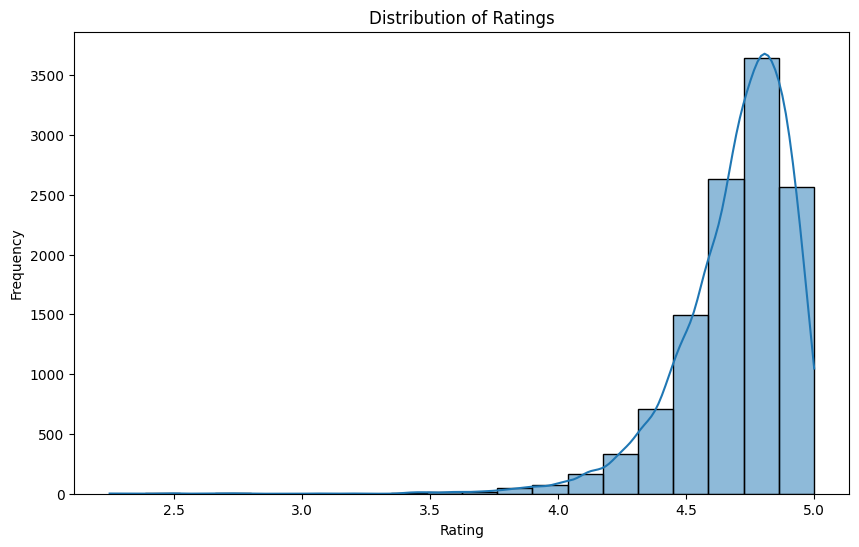

In [16]:
# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

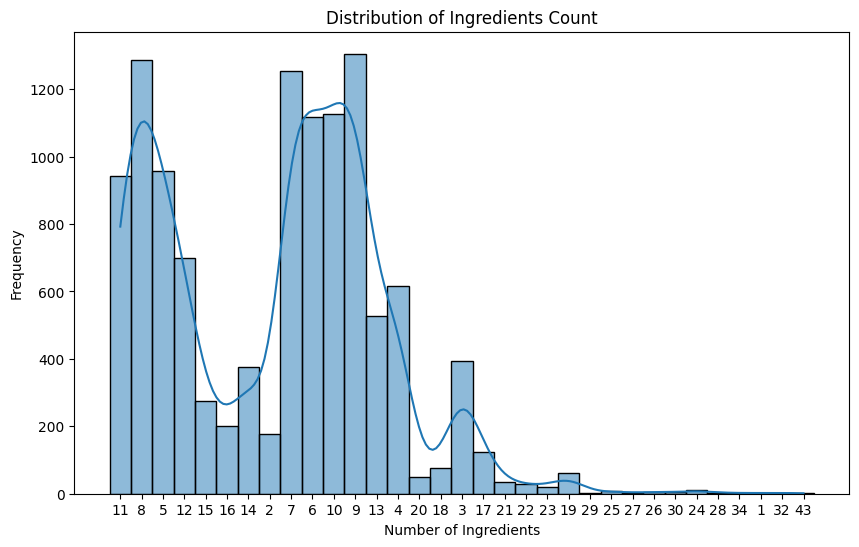

In [17]:
# Distribution of Ingredients Count
plt.figure(figsize=(10, 6))
sns.histplot(df['Fact_Ingredients'], bins=20, kde=True)
plt.title('Distribution of Ingredients Count')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()

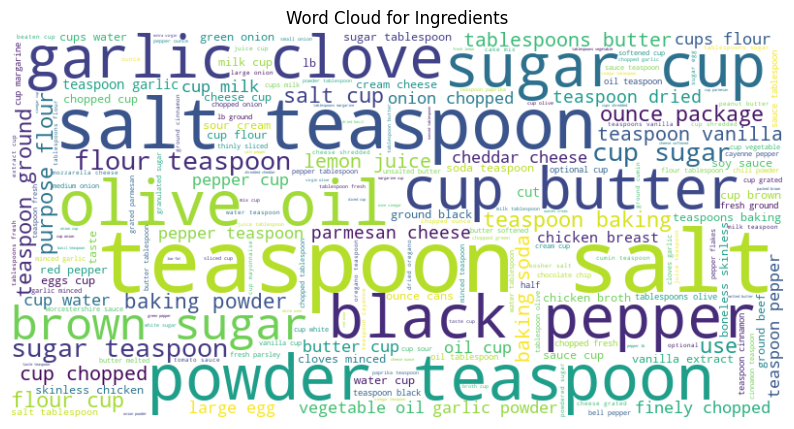

In [18]:
# Word Cloud for Ingredients
ingredients_text = ' '.join(df['Ingredients'].fillna('').str.replace('\n', ' '))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ingredients_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ingredients')
plt.show()

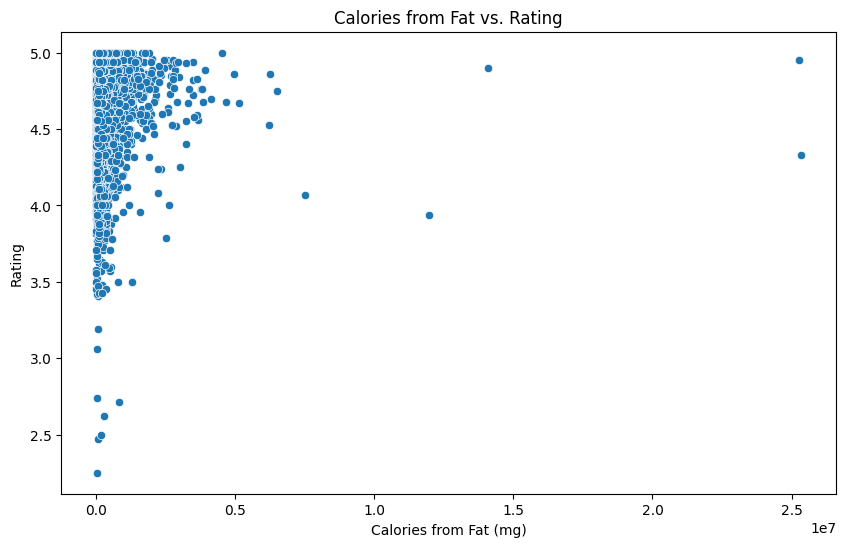

In [19]:
# Calories vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Calories from Fat', y='Rating', data=df)
plt.title('Calories from Fat vs. Rating')
plt.xlabel('Calories from Fat (mg)')
plt.ylabel('Rating')
plt.show()

In [20]:
df_processed = df.copy()

# Normalize numerical columns
numerical_cols = [
    'Fact_Ready In', 'Fact_Ingredients', 'Serving Size', 'Servings Per Recipe',
    'Calories from Fat DV', 'Calories from Fat', 'Total Fat DV', 'Total Fat',
    'Saturated Fat DV', 'Saturated Fat', 'Cholesterol DV', 'Cholesterol', 'Sodium DV',
    'Sodium', 'Total Carbohydrate DV', 'Total Carbohydrate', 'Dietary Fiber DV',
    'Dietary Fiber', 'Sugars DV', 'Sugars', 'Protein DV', 'Protein'
]
categorical_cols = ['Category', 'Fact_Yields']
text_cols = ['Name', 'Description', 'Directions', 'Ingredients']

# Preprocess numeric data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

df_processed[numerical_cols] = numeric_transformer.fit_transform(df_processed[numerical_cols])
df_processed.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein
0,Bourbon Chicken,I searched and finally found this recipe on th...,"{'Ready In:': '35mins', 'Ingredients:': '11', ...",Editor's Note: Named Bourbon Chicken because i...,"2 lbs boneless chicken breasts, cut into bite-...","{'Serving Size': '1 (330) g', 'Servings Per Re...",Chicken Breast,4.58,https://www.food.com/recipe/bourbon-chicken-45809,4,0.538218,-0.047750,None,-0.085211,-0.081579,0.051143,0.032116,0.029575,0.032138,-0.113048,-0.112703,0.296955,0.297457,0.157276,0.157566,-0.270983,-0.260966,-0.521193,-0.532440,0.014256,0.016493,0.662107,0.659198
1,Best Banana Bread,You'll never need another banana bread recipe ...,"{'Ready In:': '1hr 10mins', 'Ingredients:': '8...",Remove odd pots and pans from oven.\nPreheat o...,"1⁄2 cup butter, softened\n1 cup granulated sug...","{'Serving Size': '1 (96) g', 'Servings Per Rec...",Quick Breads,4.81,https://www.food.com/recipe/best-banana-bread-...,10,-0.240797,-0.026426,1 loaf,-0.430808,0.098900,-0.279672,-0.223337,-0.219506,-0.223316,-0.122217,-0.126457,-0.111311,-0.109131,-0.129707,-0.131920,-0.043462,-0.054025,-0.339772,-0.332971,0.064876,0.065424,-0.286110,-0.286942
2,To Die for Crock Pot Roast,"Amazing flavor, and so simple! No salt needed ...","{'Ready In:': '9hrs 5mins', 'Ingredients:': '5...",Place beef roast in crock pot.\nMix the dried ...,"1 (4 -5 lb) beef roast, any kind\n1 (1 1/4 oun...","{'Serving Size': '1 (245) g', 'Servings Per Re...",One-Dish Meal,4.58,https://www.food.com/recipe/to-die-for-crock-p...,8,-1.019811,0.262977,None,-0.210748,0.038740,-0.515968,-0.237529,-0.243228,-0.237913,-0.232254,-0.231901,0.311536,0.319316,-0.124080,-0.122002,-0.498503,-0.486326,-0.566548,-0.568707,-0.344298,-0.346273,0.651911,0.646963
3,Crock-Pot Chicken With Black Beans & Cream Cheese,I love this Crock-Pot chicken recipe for two r...,"{'Ready In:': '4hrs 3mins', 'Ingredients:': '5...","Take 4-5 frozen, yes, frozen, boneless chicken...","4 -5 boneless chicken breasts, frozen\n1 (15 1...","{'Serving Size': '1 (493) g', 'Servings Per Re...",One-Dish Meal,4.46,https://www.food.com/recipe/crock-pot-chicken-...,4,-1.019811,0.078978,None,0.155525,-0.081579,0.240180,0.224720,0.219351,0.223728,0.281250,0.286154,0.340697,0.346034,0.005344,0.002917,0.021544,0.028318,1.429080,1.444110,-0.179785,-0.179232,0.570344,0.573556
4,Creamy Cajun Chicken Pasta,N'awlin's style of chicken with an updated Alf...,"{'Ready In:': '25mins', 'Ingredients:': '12', ...",Place chicken and Cajun seasoning in a bowl an...,"2 boneless skinless chicken breast halves, cut...","{'Serving Size': '1 (373) g', 'Servings Per Re...",Chicken Breast,4.84,https://www.food.com/recipe/creamy-cajun-chick...,2,0.797889,-0.053843,None,-0.021704,-0.141738,0.523736,0.336227,0.337962,0.335033,0.693888,0.689596,0.559411,0.556371,-0.017165,-0.019732,-0.010959,-0.000935,-0.112996,-0.133503,-0.293679,-0.293967,0.437797,0.438976


In [21]:
# Preprocess categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False))
])

oe_encoded = categorical_transformer.fit_transform(df[['Category']])
encoded_df = pd.DataFrame(oe_encoded, columns=categorical_transformer['onehot'].get_feature_names_out(['Category']))
df_processed = pd.concat([df_processed, encoded_df], axis=1)
df_processed.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category_< 15 Mins,Category_< 30 Mins,Category_< 4 Hours,Category_< 60 Mins,Category_African,Category_Apple,Category_Asian,Category_Australian,Category_Bars,Category_Bass,Category_Bath/Beauty,Category_Beans,Category_Beginner Cook,Category_Berries,Category_Beverages,Category_Black Beans,Category_Breads,Category_Breakfast,Category_Broil,Category_Brown Rice,Category_Brunch,Category_Cajun,Category_Camping,Category_Canadian,Category_Candy,Category_Canning,Category_Caribbean,Category_Catfish,Category_Cauliflower,Category_Chard,Category_Cheese,Category_Cheesecake,Category_Cherries,Category_Chicken,Category_Chicken Breast,Category_Chicken Livers,Category_Chicken Thigh & Leg,Category_Chilean,Category_Chinese,Category_Chocolate Chip Cookies,Category_Chowders,Category_Christmas,Category_Clear Soups,Category_Coconut,Category_Collards,Category_Cookie and Brownie,Category_Corn,Category_Crab,Category_Crawfish,Category_Creole,Category_Curries,Category_Dairy Free,Category_Deer,Category_Dessert,Category_Drop Cookies,Category_Duck Breasts,Category_Easy,Category_Egg-free,Category_Egyptian,Category_Ethiopian,Category_European,Category_For Large Groups,Category_Free Of...,Category_Frozen,Category_Fruit,Category_Gelatin,Category_German,Category_Grains,Category_Greek,Category_Greens,Category_Gumbo,Category_Halibut,Category_Halloween,Category_Ham,Category_Healthy,Category_High Fiber,Category_High In...,Category_High Protein,Category_Homeopathy/Remedies,Category_Household Cleaners,Category_Hungarian,Category_Indian,Category_Japanese,Category_Jellies,Category_Kid-Friendly,Category_Korean,Category_Kosher,Category_Lactose-free,Category_Lamb/Sheep,Category_Lemon,Category_Lentils,Category_Lime,Category_Lobster,Category_Long-Grain Rice,Category_Low Cholesterol,Category_Low Protein,Category_Lunch,Category_Macaroni And Cheese,Category_Mahi Mahi,Category_Mango,Category_Manicotti,Category_Mashed Potatoes,Category_Meat,Category_Meatballs,Category_Meatloaf,Category_Medium-Grain Rice,Category_Melons,Category_Mexican,Category_Microwave,Category_Middle Eastern,Category_Mixer,Category_Moose,Category_Moroccan,Category_Mussels,Category_New Zealand,Category_No Shell,Category_No-Cook,Category_Norwegian,Category_Nuts,Category_One-Dish Meal,Category_Onions,Category_Orange Roughy,Category_Oranges,Category_Organ Meats,Category_Oven,Category_Peanut Butter,Category_Pears,Category_Penne,Category_Peppers,Category_Perch,Category_Pheasant,Category_Pie,Category_Pineapple,Category_Plums,Category_Polish,Category_Polynesian,Category_Pork,Category_Potato,Category_Potluck,Category_Poultry,Category_Punch,Category_Quick Breads,Category_Raspberries,Category_Rice,Category_Roast,Category_Roast Beef,Category_Salad Dressings,Category_Sauces,Category_Savory,Category_Savory Pies,Category_Scones,Category_Shakes,Category_Shells,Category_Short-Grain Rice,Category_Smoothies,Category_Sourdough,Category_South African,Category_Southwestern,Category_Soy/Tofu,Category_Spaghetti,Category_Spanish,Category_Spicy,Category_Spinach,Category_Spreads,Category_Spring,Category_Squid,Category_St. Patrick's Day,Category_Steak,Category_Stew,Category_Stocks,Category_Stove Top,Category_Strawberry,Category_Summer,Category_Swedish,Category_Sweet,Category_Swiss,Category_Szechuan,Category_Tarts,Category_Tempeh,Category_Tex-Mex,Category_Thai,Category_Thanksgiving,Category_Tilapia,Category_Toddler-Friendly,Category_Tropical,Category_Trout,Category_Tuna,Category_Turkey Breasts,Category_Veal,Category_Vegan,Category_Vegetable,Category_Very Low Carbs,Category_Weeknight,Category_White Rice,Category_Whitefish,Category_Whole Chick

In [22]:
# Custom transformer for standardizing units
class UnitStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Dictionary for standardizing units and descriptors
        self.standard_units = {
            'pounds': 'lb', 'pound': 'lb', 'lbs': 'lb', 'lb': 'lb',
            'quarts': 'qt', 'quart': 'qt', 'qts': 'qt', 'qt': 'qt',
            'cups': 'cup', 'cup': 'cup',
            'pints': 'pint', 'pint': 'pint',
            'gallons': 'gal', 'gallon': 'gal', 'gal': 'gal',
            'ounces': 'oz', 'ounce': 'oz', 'ozs': 'oz', 'oz': 'oz',
            'dozens': 'dozen', 'dozen': 'dozen',
            'tablespoons': 'tbsp', 'tablespoon': 'tbsp', 'tbsps': 'tbsp', 'tbsp': 'tbsp',
            'teaspoons': 'tsp', 'teaspoon': 'tsp', 'tsps': 'tsp', 'tsp': 'tsp',
            'loaves': 'loaf', 'loaf': 'loaf',
            'brownies': 'brownie', 'brownie': 'brownie',
            'meatloaves': 'meatloaf', 'meatloaf': 'meatloaf',
            'chimichangas': 'chimichanga', 'chimichanga': 'chimichanga',
            'pizzas': 'pizza', 'pizza': 'pizza',
            'crepes': 'crepe', 'crepe': 'crepe',
            'truffles': 'truffle', 'truffle': 'truffle',
            'rolls': 'roll', 'roll': 'roll',
            'pancakes': 'pancake', 'pancake': 'pancake',
            'muffins': 'muffin', 'muffin': 'muffin',
            'cookies': 'cookie', 'cookie': 'cookie',
            'cupcakes': 'cupcake', 'cupcake': 'cupcake',
            'bars': 'bar', 'bar': 'bar',
            'waffles': 'waffle', 'waffle': 'waffle',
            'meatballs': 'meatball', 'meatball': 'meatball',
            'biscuits': 'biscuit', 'biscuit': 'biscuit',
            'appetizers': 'appetizer', 'appetizer': 'appetizer',
            'breadsticks': 'breadstick', 'breadstick': 'breadstick',
            'buns': 'bun', 'bun': 'bun',
            'enchiladas': 'enchilada', 'enchilada': 'enchilada',
            'desserts': 'dessert', 'dessert': 'dessert',
            'servings': 'serving', 'serving': 'serving',
            'strawberries': 'strawberry', 'strawberry': 'strawberry',
            'quiches': 'quiche', 'quiche': 'quiche',
            'omelettes': 'omelette', 'omelette': 'omelette',
            'sandwiches': 'sandwich', 'sandwich': 'sandwich',
            'pretzels': 'pretzel', 'pretzel': 'pretzel',
            'mushrooms': 'mushroom', 'mushroom': 'mushroom',
            'taquitos': 'taquito', 'taquito': 'taquito',
            'batches': 'batch', 'batch': 'batch',
            'patties': 'patty', 'patty': 'patty',
            'sausages': 'sausage', 'sausage': 'sausage',
            'tamales': 'tamale', 'tamale': 'tamale',
            'lambs': 'lamb', 'lamb': 'lamb',
            'cheeseburgers': 'cheeseburger', 'cheeseburger': 'cheeseburger',
            'doughnuts': 'doughnut', 'doughnut': 'doughnut',
            'hotdogs': 'hotdog', 'hotdog': 'hotdog',
            'samosas': 'samosa', 'samosa': 'samosa',
            'pies': 'pie', 'pie': 'pie',
            'turkeys': 'turkey', 'turkey': 'turkey',
            'chickens': 'chicken', 'chicken': 'chicken',
            'potatoes': 'potato', 'potato': 'potato',
            'peppers': 'pepper', 'pepper': 'pepper',
            'eggplants': 'eggplant', 'eggplant': 'eggplant',
            'fillets': 'fillet', 'fillet': 'fillet',
            'squares': 'square', 'square': 'square',
            'slabs': 'slab', 'slab': 'slab',
            'wraps': 'wrap', 'wrap': 'wrap',
            'burritos': 'burrito', 'burrito': 'burrito',
            'slices': 'slice', 'slice': 'slice',
        }
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(self.standardize_units)
    
    def standardize_units(self, value):
        try:
            tokens = word_tokenize(value.lower())
            standardized_tokens = [self.standard_units.get(token, token) for token in tokens]
            standardized_value = ' '.join(standardized_tokens)
            standardized_value = re.sub(r'(\d+)\s+(\d+)/(\d+)', lambda m: str(int(m.group(1)) + float(m.group(2)) / float(m.group(3))), standardized_value)
            return standardized_value
        except:
            return 'None'

# Custom transformer for tokenizing
class CustomTokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.apply(word_tokenize)

# Custom transformer for encoding tokens
class TokenEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        flat_tokens = list(chain.from_iterable(X))
        self.label_encoder = LabelEncoder()
        self.encoded_tokens = self.label_encoder.fit_transform([str(token) for token in flat_tokens])
        self.token_dict = dict(zip(flat_tokens, self.encoded_tokens.ravel()))
        return self
    
    def transform(self, X, y=None):
        sequences = X.apply(lambda tokens: [self.token_dict[str(token)] for token in tokens])
        # max_len = max(sequences.apply(len))
        padded_sequences = pad_sequences(sequences, maxlen=2, padding='post')
        return padded_sequences



In [23]:
# Define the pipeline
fact_transformer = Pipeline([
    ('unit_standardizer', UnitStandardizer()),
    ('tokenizer', CustomTokenizer()),
    ('token_encoder', TokenEncoder())
])

df_processed['Fact_Yields'] = fact_transformer.fit_transform(df_processed['Fact_Yields'])
df_processed.head()

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category_< 15 Mins,Category_< 30 Mins,Category_< 4 Hours,Category_< 60 Mins,Category_African,Category_Apple,Category_Asian,Category_Australian,Category_Bars,Category_Bass,Category_Bath/Beauty,Category_Beans,Category_Beginner Cook,Category_Berries,Category_Beverages,Category_Black Beans,Category_Breads,Category_Breakfast,Category_Broil,Category_Brown Rice,Category_Brunch,Category_Cajun,Category_Camping,Category_Canadian,Category_Candy,Category_Canning,Category_Caribbean,Category_Catfish,Category_Cauliflower,Category_Chard,Category_Cheese,Category_Cheesecake,Category_Cherries,Category_Chicken,Category_Chicken Breast,Category_Chicken Livers,Category_Chicken Thigh & Leg,Category_Chilean,Category_Chinese,Category_Chocolate Chip Cookies,Category_Chowders,Category_Christmas,Category_Clear Soups,Category_Coconut,Category_Collards,Category_Cookie and Brownie,Category_Corn,Category_Crab,Category_Crawfish,Category_Creole,Category_Curries,Category_Dairy Free,Category_Deer,Category_Dessert,Category_Drop Cookies,Category_Duck Breasts,Category_Easy,Category_Egg-free,Category_Egyptian,Category_Ethiopian,Category_European,Category_For Large Groups,Category_Free Of...,Category_Frozen,Category_Fruit,Category_Gelatin,Category_German,Category_Grains,Category_Greek,Category_Greens,Category_Gumbo,Category_Halibut,Category_Halloween,Category_Ham,Category_Healthy,Category_High Fiber,Category_High In...,Category_High Protein,Category_Homeopathy/Remedies,Category_Household Cleaners,Category_Hungarian,Category_Indian,Category_Japanese,Category_Jellies,Category_Kid-Friendly,Category_Korean,Category_Kosher,Category_Lactose-free,Category_Lamb/Sheep,Category_Lemon,Category_Lentils,Category_Lime,Category_Lobster,Category_Long-Grain Rice,Category_Low Cholesterol,Category_Low Protein,Category_Lunch,Category_Macaroni And Cheese,Category_Mahi Mahi,Category_Mango,Category_Manicotti,Category_Mashed Potatoes,Category_Meat,Category_Meatballs,Category_Meatloaf,Category_Medium-Grain Rice,Category_Melons,Category_Mexican,Category_Microwave,Category_Middle Eastern,Category_Mixer,Category_Moose,Category_Moroccan,Category_Mussels,Category_New Zealand,Category_No Shell,Category_No-Cook,Category_Norwegian,Category_Nuts,Category_One-Dish Meal,Category_Onions,Category_Orange Roughy,Category_Oranges,Category_Organ Meats,Category_Oven,Category_Peanut Butter,Category_Pears,Category_Penne,Category_Peppers,Category_Perch,Category_Pheasant,Category_Pie,Category_Pineapple,Category_Plums,Category_Polish,Category_Polynesian,Category_Pork,Category_Potato,Category_Potluck,Category_Poultry,Category_Punch,Category_Quick Breads,Category_Raspberries,Category_Rice,Category_Roast,Category_Roast Beef,Category_Salad Dressings,Category_Sauces,Category_Savory,Category_Savory Pies,Category_Scones,Category_Shakes,Category_Shells,Category_Short-Grain Rice,Category_Smoothies,Category_Sourdough,Category_South African,Category_Southwestern,Category_Soy/Tofu,Category_Spaghetti,Category_Spanish,Category_Spicy,Category_Spinach,Category_Spreads,Category_Spring,Category_Squid,Category_St. Patrick's Day,Category_Steak,Category_Stew,Category_Stocks,Category_Stove Top,Category_Strawberry,Category_Summer,Category_Swedish,Category_Sweet,Category_Swiss,Category_Szechuan,Category_Tarts,Category_Tempeh,Category_Tex-Mex,Category_Thai,Category_Thanksgiving,Category_Tilapia,Category_Toddler-Friendly,Category_Tropical,Category_Trout,Category_Tuna,Category_Turkey Breasts,Category_Veal,Category_Vegan,Category_Vegetable,Category_Very Low Carbs,Category_Weeknight,Category_White Rice,Category_Whitefish,Category_Whole Chick

In [24]:
# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_cols),
        ('category', categorical_transformer, ['Category']),
        ('fact', fact_transformer, 'Fact_Yields')
    ],
    remainder='drop')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
pipeline.fit(df)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Fact_Ready In',
                                                   'Fact_Ingredients',
                                                   'Serving Size',
                                                   'Servings Per Recipe',
                                                   'Calories from Fat DV',
                                                   'Calories from Fat',
                                                   'Total Fat DV', 'Total Fat',
                                                   'Saturated Fat DV',
                                                   'Saturated Fat',
                                                   'Cholesterol DV',
                                                   'Ch...
                                                   'Sugars', 'Protein DV',
                                                   'Protein']),
                                                 ('category',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Category']),
                                                 ('fact',
                                                  Pipeline(steps=[('unit_standardizer',
                                                                   UnitStandardizer()),
                                                                  ('tokenizer',
                                                                   CustomTokenizer()),
                                                                  ('token_encoder',
                                                                   TokenEncoder())]),
                                                  'Fact_Yields')]))])

In [25]:
df_processed[df_processed['Name'].isnull()]

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category_< 15 Mins,Category_< 30 Mins,Category_< 4 Hours,Category_< 60 Mins,Category_African,Category_Apple,Category_Asian,Category_Australian,Category_Bars,Category_Bass,Category_Bath/Beauty,Category_Beans,Category_Beginner Cook,Category_Berries,Category_Beverages,Category_Black Beans,Category_Breads,Category_Breakfast,Category_Broil,Category_Brown Rice,Category_Brunch,Category_Cajun,Category_Camping,Category_Canadian,Category_Candy,Category_Canning,Category_Caribbean,Category_Catfish,Category_Cauliflower,Category_Chard,Category_Cheese,Category_Cheesecake,Category_Cherries,Category_Chicken,Category_Chicken Breast,Category_Chicken Livers,Category_Chicken Thigh & Leg,Category_Chilean,Category_Chinese,Category_Chocolate Chip Cookies,Category_Chowders,Category_Christmas,Category_Clear Soups,Category_Coconut,Category_Collards,Category_Cookie and Brownie,Category_Corn,Category_Crab,Category_Crawfish,Category_Creole,Category_Curries,Category_Dairy Free,Category_Deer,Category_Dessert,Category_Drop Cookies,Category_Duck Breasts,Category_Easy,Category_Egg-free,Category_Egyptian,Category_Ethiopian,Category_European,Category_For Large Groups,Category_Free Of...,Category_Frozen,Category_Fruit,Category_Gelatin,Category_German,Category_Grains,Category_Greek,Category_Greens,Category_Gumbo,Category_Halibut,Category_Halloween,Category_Ham,Category_Healthy,Category_High Fiber,Category_High In...,Category_High Protein,Category_Homeopathy/Remedies,Category_Household Cleaners,Category_Hungarian,Category_Indian,Category_Japanese,Category_Jellies,Category_Kid-Friendly,Category_Korean,Category_Kosher,Category_Lactose-free,Category_Lamb/Sheep,Category_Lemon,Category_Lentils,Category_Lime,Category_Lobster,Category_Long-Grain Rice,Category_Low Cholesterol,Category_Low Protein,Category_Lunch,Category_Macaroni And Cheese,Category_Mahi Mahi,Category_Mango,Category_Manicotti,Category_Mashed Potatoes,Category_Meat,Category_Meatballs,Category_Meatloaf,Category_Medium-Grain Rice,Category_Melons,Category_Mexican,Category_Microwave,Category_Middle Eastern,Category_Mixer,Category_Moose,Category_Moroccan,Category_Mussels,Category_New Zealand,Category_No Shell,Category_No-Cook,Category_Norwegian,Category_Nuts,Category_One-Dish Meal,Category_Onions,Category_Orange Roughy,Category_Oranges,Category_Organ Meats,Category_Oven,Category_Peanut Butter,Category_Pears,Category_Penne,Category_Peppers,Category_Perch,Category_Pheasant,Category_Pie,Category_Pineapple,Category_Plums,Category_Polish,Category_Polynesian,Category_Pork,Category_Potato,Category_Potluck,Category_Poultry,Category_Punch,Category_Quick Breads,Category_Raspberries,Category_Rice,Category_Roast,Category_Roast Beef,Category_Salad Dressings,Category_Sauces,Category_Savory,Category_Savory Pies,Category_Scones,Category_Shakes,Category_Shells,Category_Short-Grain Rice,Category_Smoothies,Category_Sourdough,Category_South African,Category_Southwestern,Category_Soy/Tofu,Category_Spaghetti,Category_Spanish,Category_Spicy,Category_Spinach,Category_Spreads,Category_Spring,Category_Squid,Category_St. Patrick's Day,Category_Steak,Category_Stew,Category_Stocks,Category_Stove Top,Category_Strawberry,Category_Summer,Category_Swedish,Category_Sweet,Category_Swiss,Category_Szechuan,Category_Tarts,Category_Tempeh,Category_Tex-Mex,Category_Thai,Category_Thanksgiving,Category_Tilapia,Category_Toddler-Friendly,Category_Tropical,Category_Trout,Category_Tuna,Category_Turkey Breasts,Category_Veal,Category_Vegan,Category_Vegetable,Category_Very Low Carbs,Category_Weeknight,Category_White Rice,Category_Whitefish,Category_Whole Chick

In [26]:
df_processed = df_processed[df_processed['Name'].notnull()]
df_processed[df_processed['Name'].isnull()]

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category_< 15 Mins,Category_< 30 Mins,Category_< 4 Hours,Category_< 60 Mins,Category_African,Category_Apple,Category_Asian,Category_Australian,Category_Bars,Category_Bass,Category_Bath/Beauty,Category_Beans,Category_Beginner Cook,Category_Berries,Category_Beverages,Category_Black Beans,Category_Breads,Category_Breakfast,Category_Broil,Category_Brown Rice,Category_Brunch,Category_Cajun,Category_Camping,Category_Canadian,Category_Candy,Category_Canning,Category_Caribbean,Category_Catfish,Category_Cauliflower,Category_Chard,Category_Cheese,Category_Cheesecake,Category_Cherries,Category_Chicken,Category_Chicken Breast,Category_Chicken Livers,Category_Chicken Thigh & Leg,Category_Chilean,Category_Chinese,Category_Chocolate Chip Cookies,Category_Chowders,Category_Christmas,Category_Clear Soups,Category_Coconut,Category_Collards,Category_Cookie and Brownie,Category_Corn,Category_Crab,Category_Crawfish,Category_Creole,Category_Curries,Category_Dairy Free,Category_Deer,Category_Dessert,Category_Drop Cookies,Category_Duck Breasts,Category_Easy,Category_Egg-free,Category_Egyptian,Category_Ethiopian,Category_European,Category_For Large Groups,Category_Free Of...,Category_Frozen,Category_Fruit,Category_Gelatin,Category_German,Category_Grains,Category_Greek,Category_Greens,Category_Gumbo,Category_Halibut,Category_Halloween,Category_Ham,Category_Healthy,Category_High Fiber,Category_High In...,Category_High Protein,Category_Homeopathy/Remedies,Category_Household Cleaners,Category_Hungarian,Category_Indian,Category_Japanese,Category_Jellies,Category_Kid-Friendly,Category_Korean,Category_Kosher,Category_Lactose-free,Category_Lamb/Sheep,Category_Lemon,Category_Lentils,Category_Lime,Category_Lobster,Category_Long-Grain Rice,Category_Low Cholesterol,Category_Low Protein,Category_Lunch,Category_Macaroni And Cheese,Category_Mahi Mahi,Category_Mango,Category_Manicotti,Category_Mashed Potatoes,Category_Meat,Category_Meatballs,Category_Meatloaf,Category_Medium-Grain Rice,Category_Melons,Category_Mexican,Category_Microwave,Category_Middle Eastern,Category_Mixer,Category_Moose,Category_Moroccan,Category_Mussels,Category_New Zealand,Category_No Shell,Category_No-Cook,Category_Norwegian,Category_Nuts,Category_One-Dish Meal,Category_Onions,Category_Orange Roughy,Category_Oranges,Category_Organ Meats,Category_Oven,Category_Peanut Butter,Category_Pears,Category_Penne,Category_Peppers,Category_Perch,Category_Pheasant,Category_Pie,Category_Pineapple,Category_Plums,Category_Polish,Category_Polynesian,Category_Pork,Category_Potato,Category_Potluck,Category_Poultry,Category_Punch,Category_Quick Breads,Category_Raspberries,Category_Rice,Category_Roast,Category_Roast Beef,Category_Salad Dressings,Category_Sauces,Category_Savory,Category_Savory Pies,Category_Scones,Category_Shakes,Category_Shells,Category_Short-Grain Rice,Category_Smoothies,Category_Sourdough,Category_South African,Category_Southwestern,Category_Soy/Tofu,Category_Spaghetti,Category_Spanish,Category_Spicy,Category_Spinach,Category_Spreads,Category_Spring,Category_Squid,Category_St. Patrick's Day,Category_Steak,Category_Stew,Category_Stocks,Category_Stove Top,Category_Strawberry,Category_Summer,Category_Swedish,Category_Sweet,Category_Swiss,Category_Szechuan,Category_Tarts,Category_Tempeh,Category_Tex-Mex,Category_Thai,Category_Thanksgiving,Category_Tilapia,Category_Toddler-Friendly,Category_Tropical,Category_Trout,Category_Tuna,Category_Turkey Breasts,Category_Veal,Category_Vegan,Category_Vegetable,Category_Very Low Carbs,Category_Weeknight,Category_White Rice,Category_Whitefish,Category_Whole Chick

In [27]:
df_processed['Description'] = df['Description'].astype(str).fillna('')
df_processed[df_processed['Description'].isnull()]

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category_< 15 Mins,Category_< 30 Mins,Category_< 4 Hours,Category_< 60 Mins,Category_African,Category_Apple,Category_Asian,Category_Australian,Category_Bars,Category_Bass,Category_Bath/Beauty,Category_Beans,Category_Beginner Cook,Category_Berries,Category_Beverages,Category_Black Beans,Category_Breads,Category_Breakfast,Category_Broil,Category_Brown Rice,Category_Brunch,Category_Cajun,Category_Camping,Category_Canadian,Category_Candy,Category_Canning,Category_Caribbean,Category_Catfish,Category_Cauliflower,Category_Chard,Category_Cheese,Category_Cheesecake,Category_Cherries,Category_Chicken,Category_Chicken Breast,Category_Chicken Livers,Category_Chicken Thigh & Leg,Category_Chilean,Category_Chinese,Category_Chocolate Chip Cookies,Category_Chowders,Category_Christmas,Category_Clear Soups,Category_Coconut,Category_Collards,Category_Cookie and Brownie,Category_Corn,Category_Crab,Category_Crawfish,Category_Creole,Category_Curries,Category_Dairy Free,Category_Deer,Category_Dessert,Category_Drop Cookies,Category_Duck Breasts,Category_Easy,Category_Egg-free,Category_Egyptian,Category_Ethiopian,Category_European,Category_For Large Groups,Category_Free Of...,Category_Frozen,Category_Fruit,Category_Gelatin,Category_German,Category_Grains,Category_Greek,Category_Greens,Category_Gumbo,Category_Halibut,Category_Halloween,Category_Ham,Category_Healthy,Category_High Fiber,Category_High In...,Category_High Protein,Category_Homeopathy/Remedies,Category_Household Cleaners,Category_Hungarian,Category_Indian,Category_Japanese,Category_Jellies,Category_Kid-Friendly,Category_Korean,Category_Kosher,Category_Lactose-free,Category_Lamb/Sheep,Category_Lemon,Category_Lentils,Category_Lime,Category_Lobster,Category_Long-Grain Rice,Category_Low Cholesterol,Category_Low Protein,Category_Lunch,Category_Macaroni And Cheese,Category_Mahi Mahi,Category_Mango,Category_Manicotti,Category_Mashed Potatoes,Category_Meat,Category_Meatballs,Category_Meatloaf,Category_Medium-Grain Rice,Category_Melons,Category_Mexican,Category_Microwave,Category_Middle Eastern,Category_Mixer,Category_Moose,Category_Moroccan,Category_Mussels,Category_New Zealand,Category_No Shell,Category_No-Cook,Category_Norwegian,Category_Nuts,Category_One-Dish Meal,Category_Onions,Category_Orange Roughy,Category_Oranges,Category_Organ Meats,Category_Oven,Category_Peanut Butter,Category_Pears,Category_Penne,Category_Peppers,Category_Perch,Category_Pheasant,Category_Pie,Category_Pineapple,Category_Plums,Category_Polish,Category_Polynesian,Category_Pork,Category_Potato,Category_Potluck,Category_Poultry,Category_Punch,Category_Quick Breads,Category_Raspberries,Category_Rice,Category_Roast,Category_Roast Beef,Category_Salad Dressings,Category_Sauces,Category_Savory,Category_Savory Pies,Category_Scones,Category_Shakes,Category_Shells,Category_Short-Grain Rice,Category_Smoothies,Category_Sourdough,Category_South African,Category_Southwestern,Category_Soy/Tofu,Category_Spaghetti,Category_Spanish,Category_Spicy,Category_Spinach,Category_Spreads,Category_Spring,Category_Squid,Category_St. Patrick's Day,Category_Steak,Category_Stew,Category_Stocks,Category_Stove Top,Category_Strawberry,Category_Summer,Category_Swedish,Category_Sweet,Category_Swiss,Category_Szechuan,Category_Tarts,Category_Tempeh,Category_Tex-Mex,Category_Thai,Category_Thanksgiving,Category_Tilapia,Category_Toddler-Friendly,Category_Tropical,Category_Trout,Category_Tuna,Category_Turkey Breasts,Category_Veal,Category_Vegan,Category_Vegetable,Category_Very Low Carbs,Category_Weeknight,Category_White Rice,Category_Whitefish,Category_Whole Chick

In [28]:
df_processed[df_processed['Ingredients'].isnull()]

,Name,Description,Facts,Directions,Ingredients,Nutrition,Category,Rating,URL,Fact_Serves,Fact_Ingredients,Fact_Ready In,Fact_Yields,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category_< 15 Mins,Category_< 30 Mins,Category_< 4 Hours,Category_< 60 Mins,Category_African,Category_Apple,Category_Asian,Category_Australian,Category_Bars,Category_Bass,Category_Bath/Beauty,Category_Beans,Category_Beginner Cook,Category_Berries,Category_Beverages,Category_Black Beans,Category_Breads,Category_Breakfast,Category_Broil,Category_Brown Rice,Category_Brunch,Category_Cajun,Category_Camping,Category_Canadian,Category_Candy,Category_Canning,Category_Caribbean,Category_Catfish,Category_Cauliflower,Category_Chard,Category_Cheese,Category_Cheesecake,Category_Cherries,Category_Chicken,Category_Chicken Breast,Category_Chicken Livers,Category_Chicken Thigh & Leg,Category_Chilean,Category_Chinese,Category_Chocolate Chip Cookies,Category_Chowders,Category_Christmas,Category_Clear Soups,Category_Coconut,Category_Collards,Category_Cookie and Brownie,Category_Corn,Category_Crab,Category_Crawfish,Category_Creole,Category_Curries,Category_Dairy Free,Category_Deer,Category_Dessert,Category_Drop Cookies,Category_Duck Breasts,Category_Easy,Category_Egg-free,Category_Egyptian,Category_Ethiopian,Category_European,Category_For Large Groups,Category_Free Of...,Category_Frozen,Category_Fruit,Category_Gelatin,Category_German,Category_Grains,Category_Greek,Category_Greens,Category_Gumbo,Category_Halibut,Category_Halloween,Category_Ham,Category_Healthy,Category_High Fiber,Category_High In...,Category_High Protein,Category_Homeopathy/Remedies,Category_Household Cleaners,Category_Hungarian,Category_Indian,Category_Japanese,Category_Jellies,Category_Kid-Friendly,Category_Korean,Category_Kosher,Category_Lactose-free,Category_Lamb/Sheep,Category_Lemon,Category_Lentils,Category_Lime,Category_Lobster,Category_Long-Grain Rice,Category_Low Cholesterol,Category_Low Protein,Category_Lunch,Category_Macaroni And Cheese,Category_Mahi Mahi,Category_Mango,Category_Manicotti,Category_Mashed Potatoes,Category_Meat,Category_Meatballs,Category_Meatloaf,Category_Medium-Grain Rice,Category_Melons,Category_Mexican,Category_Microwave,Category_Middle Eastern,Category_Mixer,Category_Moose,Category_Moroccan,Category_Mussels,Category_New Zealand,Category_No Shell,Category_No-Cook,Category_Norwegian,Category_Nuts,Category_One-Dish Meal,Category_Onions,Category_Orange Roughy,Category_Oranges,Category_Organ Meats,Category_Oven,Category_Peanut Butter,Category_Pears,Category_Penne,Category_Peppers,Category_Perch,Category_Pheasant,Category_Pie,Category_Pineapple,Category_Plums,Category_Polish,Category_Polynesian,Category_Pork,Category_Potato,Category_Potluck,Category_Poultry,Category_Punch,Category_Quick Breads,Category_Raspberries,Category_Rice,Category_Roast,Category_Roast Beef,Category_Salad Dressings,Category_Sauces,Category_Savory,Category_Savory Pies,Category_Scones,Category_Shakes,Category_Shells,Category_Short-Grain Rice,Category_Smoothies,Category_Sourdough,Category_South African,Category_Southwestern,Category_Soy/Tofu,Category_Spaghetti,Category_Spanish,Category_Spicy,Category_Spinach,Category_Spreads,Category_Spring,Category_Squid,Category_St. Patrick's Day,Category_Steak,Category_Stew,Category_Stocks,Category_Stove Top,Category_Strawberry,Category_Summer,Category_Swedish,Category_Sweet,Category_Swiss,Category_Szechuan,Category_Tarts,Category_Tempeh,Category_Tex-Mex,Category_Thai,Category_Thanksgiving,Category_Tilapia,Category_Toddler-Friendly,Category_Tropical,Category_Trout,Category_Tuna,Category_Turkey Breasts,Category_Veal,Category_Vegan,Category_Vegetable,Category_Very Low Carbs,Category_Weeknight,Category_White Rice,Category_Whitefish,Category_Whole Chick

In [29]:
# Combine all text fields into a single dataset
df_processed['text'] = df_processed['Name'] + ' ' + df_processed['Description'] + ' ' + df_processed['Ingredients'] + ' ' + df_processed['Directions']

In [30]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=50000, lower=True)
tokenizer.fit_on_texts(df_processed['text'].values)
word_index = tokenizer.word_index

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(df_processed['text'].values)
padded_sequences = pad_sequences(sequences, maxlen=250)

# Split the data into training and validation sets
# X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(padded_sequences, df_processed['text'], test_size=0.2, random_state=42)
# X_train_num, X_val_num, y_train_num, y_val_num = train_test_split(df_processed[numerical_cols+categorical_cols], df_processed['text'], test_size=0.2, random_state=42)
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(padded_sequences, df_processed['text'], test_size=0.2, random_state=42)
X_train_num, X_val_num = train_test_split(df_processed[numerical_cols + categorical_cols], test_size=0.2, random_state=42)

In [31]:
X_train_text.shape, X_train_num.shape

((9352, 250), (9352, 24))

In [32]:
X_train_num.head()

,Fact_Ready In,Fact_Ingredients,Serving Size,Servings Per Recipe,Calories from Fat DV,Calories from Fat,Total Fat DV,Total Fat,Saturated Fat DV,Saturated Fat,Cholesterol DV,Cholesterol,Sodium DV,Sodium,Total Carbohydrate DV,Total Carbohydrate,Dietary Fiber DV,Dietary Fiber,Sugars DV,Sugars,Protein DV,Protein,Category,Fact_Yields
714,-0.050797,-1.019811,-0.519422,0.520016,1.657958,-0.298351,-0.302533,-0.298127,-0.278103,-0.277747,-0.330024,-0.332585,-0.197232,-0.198225,-0.466000,-0.475492,-0.475838,-0.459906,-0.306334,-0.304091,-0.326893,-0.329763,Cheesecake,236
1076,-0.067856,-1.019811,-0.169395,-0.171818,-0.468709,-0.245638,-0.243228,-0.245212,-0.158896,-0.153964,-0.242539,-0.242232,-0.146588,-0.146785,-0.108468,-0.095196,-0.475838,-0.459906,0.081749,0.080610,-0.184151,-0.184987,Beverages,236
9897,-0.019724,1.576903,-0.088165,0.038740,-1.319375,-0.338899,-0.338116,-0.338270,-0.378970,-0.383192,-0.402929,-0.408365,-0.197232,-0.196302,0.021544,0.035902,2.608314,2.586519,-0.188222,-0.189355,-0.041409,-0.044290,< 4 Hours,236
7292,-0.035565,-0.240797,-0.481023,0.279378,-0.326931,-0.255775,-0.255089,-0.256160,-0.177236,-0.176887,-0.125892,-0.118361,-0.191605,-0.189667,-0.108468,-0.121200,-0.521193,-0.496173,0.035348,0.035053,-0.296305,-0.299177,Dessert,61
2422,-0.062982,-0.240797,0.430231,-0.171818,-0.941301,-0.369310,-0.373699,-0.369289,-0.388139,-0.387777,-0.315443,-0.318012,-0.129707,-0.128825,-0.335989,-0.323807,-0.249062,-0.260437,-0.323207,-0.324338,-0.296305,-0.293059,Breakfast,24


In [33]:
embedding_dim = 100
latent_dim = 256
input_length = 250

def build_model():
    # Encoder
    encoder_inputs = Input(shape=(input_length,))
    encoder_embedding = Embedding(input_dim=50000, output_dim=embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(input_length,))
    decoder_embedding = Embedding(input_dim=50000, output_dim=embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Attention
    attention = tf.keras.layers.Attention()
    attention_output = attention([decoder_outputs, encoder_outputs])
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

    # Numerical features input
    numerical_inputs = Input(shape=(227,))  # Ensure shape matches numerical feature length
    numerical_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numerical_inputs)
    numerical_dense = Dropout(0.5)(numerical_dense)

    # Repeat the numerical features to match the sequence length
    numerical_repeated = RepeatVector(input_length)(numerical_dense)

    # Combine all inputs
    combined_inputs = Concatenate(axis=-1)([decoder_concat_input, numerical_repeated])

    # Output layer
    decoder_dense = Dense(50000, activation='softmax')
    decoder_outputs = decoder_dense(combined_inputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs, numerical_inputs], decoder_outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 250)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 250)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 250, 100)          │       5,000,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 250, 100)          │       5,000,000 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ [(None, 250, 256), (None, │         365,568 │ embedding[0][0]            │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 227)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_1 (LSTM)                 │ [(None, 250, 256), (None, │         365,568 │ embedding_1[0][0],         │
│                               │ 256), (None, 256)]        │                 │ lstm[0][1], lstm[0][2]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │          14,592 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 250, 256)          │               0 │ lstm_1[0][0], lstm[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 250, 512)          │               0 │ lstm_1[0][0],              │
│                               │                           │                 │ attention[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector (RepeatVector)  │ (None, 250, 64)           │               0 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 250, 576)          │               0 │ concatenate[0][0],         │
│                               │                           │                 │ repeat_vector[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 250, 50000)        │      28,850,000 │ concatenate_1[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 39,595,728 (151.05 MB)

 Trainable params: 39,595,728 (151.05 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
X_train_text

array([[   0,    0,    0, ...,  288,  753,  988],
       [   0,    0,    0, ...,   52,    6,  107],
       [   0,    0,    0, ...,    4, 2725,  138],
       ...,
       [   0,    0,    0, ...,   18,  752,   71],
       [   0,    0,    0, ...,   34,    1,   81],
       [   0,    0,    0, ...,  378,  114,  397]])

In [35]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sequences = self.tokenizer.texts_to_sequences(X)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_len)
        return padded_sequences

# Fit and transform numerical features using the original indices
X_train_num = pipeline.transform(X_train_num)
X_val_num = pipeline.transform(X_val_num)

In [36]:
X_train_num.shape, len(numerical_cols)

((9352, 227), 22)

In [37]:
# Preprocess text data using the custom transformer
text_preprocessor = TextPreprocessor(tokenizer, max_len=250)
X_train_text = text_preprocessor.transform(y_train_text)
X_val_text = text_preprocessor.transform(y_val_text)

# Prepare data for the decoder
y_train_in = X_train_text[:, :-1]
y_train_out = X_train_text[:, 1:]
y_train_in = pad_sequences(y_train_in, maxlen=250, padding='post')  # Ensure the same length

y_val_in = X_val_text[:, :-1]
y_val_out = X_val_text[:, 1:]
y_val_in = pad_sequences(y_val_in, maxlen=250, padding='post')  # Ensure the same length

# Adjust y_train_out and y_val_out to have the correct shape (None, 250, 1)
y_train_out = pad_sequences(y_train_out, maxlen=250, padding='post')  # Ensure the same length
y_val_out = pad_sequences(y_val_out, maxlen=250, padding='post')  # Ensure the same length

# Reshape y_train_out for compatibility
y_train_out = y_train_out.reshape(y_train_out.shape[0], -1, 1)
y_val_out = y_val_out.reshape(y_val_out.shape[0], -1, 1)

In [38]:
X_train_text.shape, y_train_in.shape, X_train_num.shape, y_train_out.shape, '--', X_val_text.shape, y_val_in.shape, X_val_num.shape, y_val_out.shape

((9352, 250),
 (9352, 250),
 (9352, 227),
 (9352, 250, 1),
 '--',
 (2339, 250),
 (2339, 250),
 (2339, 227),
 (2339, 250, 1))

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit([X_train_text, y_train_in, X_train_num], y_train_out,
                    validation_data=([X_val_text, y_val_in, X_val_num], y_val_out),
                    epochs=10, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
val_loss, val_accuracy = model.evaluate([X_val_text, y_val_in, X_val_num], y_val_out)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch 1/10


In [ ]:
def generate_recipe(model, tokenizer, seed_text, num_features, max_sequence_len=250):
    for _ in range(max_sequence_len):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')
        num_features_repeated = RepeatVector(max_sequence_len)(num_features)
        predicted = model.predict([token_list, token_list, num_features_repeated], verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted.argmax():
                output_word = word
                break
        seed_text += " " + output_word
        if output_word == "endseq":
            break
    return seed_text

# Generate a new recipe
seed_text = "chocolate cake with"
num_features = pipeline.transform([df[numerical_columns].iloc[0]])
num_features = tf.convert_to_tensor(num_features)
print(generate_recipe(model, tokenizer, seed_text, num_features))